# Notes:

## Starting from Spot return simulator:
- Read AMZN1.csv to get Amazon spot data for years 2011 - 2020 (2514 data points).
- Read the df_nu xlsx to load the saved volatility that we got from the simulator (Considered only the first 1500 points).
- Now you have the spot data and its modeled volatility.

## DLV simulator:
- Load the Auto-encoder keys: ae_model.pth needed for decoder function.
- Directly load the compressed DLVs (1500 time stamps): compressed_latent_codes.xlxs.
- Get the log of the series and then standard scale. Use that to get p-lagged (p = 1,2) data.
- Load the flows with the keys and parameters. Use that to sample data and get simulated DLVs.

## Getting back Call prices:
- Use the simulated DLVs and the decoder to get the uncompressed DLV grids.
- Use that to get call prices. The spot prices are in the AMZN1.csv(Remember, use only the first 1:1500 points for p = 1,2:1500 for p = 2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import kstest, norm
from scipy.stats import kurtosis, skew
from statsmodels.tsa.stattools import acf 
from tqdm import tqdm
import math
import torch.nn.functional as F

In [4]:
df = pd.read_csv("AMZN1.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df[(df['Date'].dt.year > 2010) & (df['Date'].dt.year < 2021)]
df = df.sort_values(by='Date')
df['Day'] = (df['Date'] - df['Date'].min()).dt.days
df = df.sort_values(by = 'Day')
df['log_return'] = np.log(df['Adjusted Close']).diff()
df['err_log_return'] = df['log_return'] * 10
df.dropna(inplace=True) 

def make_log_return_df(a, n=1000, seed=42):
    
    np.random.seed(seed)
    mean = -a**2 / 2
    std = a
    log_returns = np.random.normal(loc=mean, scale=std, size=n)
    df = pd.DataFrame({'log_return': log_returns})
    return df

df_fake = make_log_return_df(a = 0.2, n = 2000)

In [5]:
def prepare_lagged_data(df, col='log_return', num_lags=2):
    
    series = df[col].dropna().values
    N = len(series)

    X = np.stack([series[i:N - num_lags + i] for i in range(num_lags)], axis=1)
    y = series[num_lags:]

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X, y = prepare_lagged_data(df, col='log_return', num_lags=2)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42,shuffle=True)

print(f"\nShape of X (lagged inputs y_t): {X.shape}") 
print(f"Shape of y (target r_{{t+1}}): {y.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Shape of X (lagged inputs y_t): torch.Size([2514, 2])
Shape of y (target r_{t+1}): torch.Size([2514])
X_train shape: torch.Size([1508, 2])
y_train shape: torch.Size([1508])
X_val shape: torch.Size([503, 2])
y_val shape: torch.Size([503])
X_test shape: torch.Size([503, 2])
y_test shape: torch.Size([503])


In [6]:
def nll_loss(r_true, nu):
    var = nu**2 + 1e-8
    mean = -0.5 * var
    return 0.5 * torch.log(2 * torch.pi * var) + ((r_true - mean)**2) / (2 * var)

def compute_latent_z(r_true, nu):
    return (r_true + 0.5 * nu**2) / (nu + 1e-8)

def compute_pred(model, X):
    with torch.no_grad():
        nu = model(X)
    nu = np.asarray(nu)
    z = np.random.normal(0, 1, size=nu.shape)
    return nu * z - 0.5 * nu**2

def summarize_distribution(data):
    data = np.asarray(data)
    
    # Basic stats
    mean = np.mean(data)
    std = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data, fisher=True)  
    q25, q50, q75 = np.percentile(data, [25, 50, 75])

    # Print statistics
    print(f"  Mean      : {mean:.6f}")
    print(f"  Std Dev   : {std:.6f}")
    print(f"  Skewness  : {skewness:.6f}")
    print(f"  Kurtosis  : {kurt:.6f}")
    print(f"  Quantiles : 25%={q25:.4f}, 50%={q50:.4f}, 75%={q75:.4f}")


class RealizedVolNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        a = self.net(x)
        nu = torch.exp(a).squeeze()  
        return nu

In [7]:
def train_with_ks_tracking(X_train, y_train, X_val, y_val,
                           input_dim, lr=1e-3, epochs=500):
    model = RealizedVolNet(input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    consecutive_count = 0
    model_saved = False

    train_losses, val_losses, train_losses_ND = [], [], []
    train_pvalues, val_pvalues = [], []
    nus_train_ND = []
    nus_val = []
    for epoch in range(epochs):
        
        model.train()
        optimizer.zero_grad()
        nu_train = model(X_train)
        loss = torch.mean(nll_loss(y_train, nu_train))
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            nu_train_ND = model(X_train)
            nus_train_ND.append(torch.mean(nu_train_ND).item())
            loss_train_ND = torch.mean(nll_loss(y_train, nu_train_ND)).item()

            nu_val = model(X_val)
            nus_val.append(torch.mean(nu_val).item())
            loss_val = torch.mean(nll_loss(y_val, nu_val)).item()

            z_train = compute_latent_z(y_train, nu_train_ND).cpu().numpy()
            z_val = compute_latent_z(y_val, nu_val).cpu().numpy()

            ks_train = kstest(z_train, 'norm').pvalue
            ks_val = kstest(z_val, 'norm').pvalue

        train_losses.append(loss.item())
        train_losses_ND.append(loss_train_ND)
        val_losses.append(loss_val)
        train_pvalues.append(ks_train)
        val_pvalues.append(ks_val)
        
        if (epoch+1 ) % 50 == 0:
            print(f"Epoch {epoch:03d}: "
              f"Train NLL = {loss.item():.4f}, "
              f"Train ND NLL = {loss_train_ND:.4f}, "
              f"Val NLL = {loss_val:.4f}, "
              f"KS p (train) = {ks_train:.4f}, "
              f"KS p (Val) = {ks_val:.4f}")

        if epoch > 300:
            if loss_train_ND < loss_val:
                consecutive_count += 1
                if consecutive_count >= 1 and not model_saved:
                    print(f"\nSaving model at epoch {epoch} "
                          f"(train_loss_ND < test_loss for 5 consecutive epochs)")
                    print(f"Epoch {epoch:03d}: "
                      f"Train NLL = {loss.item():.4f}, "
                      f"Train ND NLL = {loss_train_ND:.4f}, "
                      f"Val NLL = {loss_val:.4f}, "
                      f"KS p (train) = {ks_train:.4f}, "
                      f"KS p (Val) = {ks_val:.4f}")
                    torch.save(model.state_dict(), "model_trainND_better_than_test3.pth")
                    model_saved = True
            else:
                consecutive_count = 0

    return model, {
        'train_losses': train_losses,
        'train_losses_ND': train_losses_ND,
        'val_losses': val_losses,
        'train_pvalues': train_pvalues,
        'val_pvalues': val_pvalues,
        'nus_train_ND': nus_train_ND,
        'nus_val' : nus_val
    }


In [8]:
model, history = train_with_ks_tracking(X_train, y_train, X_val, y_val,
                                        input_dim=X_train.shape[1], lr=1e-3, epochs=200)

Epoch 049: Train NLL = -2.1584, Train ND NLL = -2.2573, Val NLL = -2.2461, KS p (train) = 0.0000, KS p (Val) = 0.0000
Epoch 099: Train NLL = -2.4156, Train ND NLL = -2.5142, Val NLL = -2.4798, KS p (train) = 0.0000, KS p (Val) = 0.0000
Epoch 149: Train NLL = -2.4572, Train ND NLL = -2.5214, Val NLL = -2.4828, KS p (train) = 0.0000, KS p (Val) = 0.0000
Epoch 199: Train NLL = -2.4623, Train ND NLL = -2.5263, Val NLL = -2.4837, KS p (train) = 0.0000, KS p (Val) = 0.0000


(array([   8.,   16.,  106.,  817., 1249.,  248.,   53.,   12.,    3.,
           2.]),
 array([0.01613378, 0.01736282, 0.01859186, 0.0198209 , 0.02104994,
        0.02227898, 0.02350801, 0.02473705, 0.02596609, 0.02719513,
        0.02842417]),
 <BarContainer object of 10 artists>)

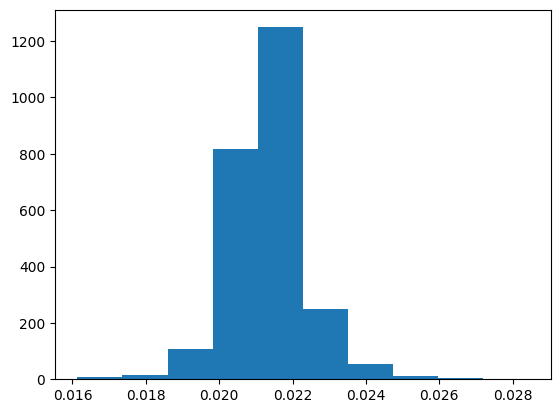

In [9]:
with torch.no_grad():
    nu_full = model(X).cpu().numpy()
plt.hist(nu_full)

In [10]:
df_nu = pd.DataFrame(nu_full, columns = ["Spot_volatility"])
df_nu.to_excel("Spot_volatiltiy.xlsx", index = False)

df_nu = pd.read_excel("Spot_volatiltiy.xlsx")
nu_full = df_nu.values

2514


In [12]:
T = 1500
strikes = np.linspace(0.8,1.2,9)  
maturities = np.array([20, 40, 60, 120]) 
K, M = len(strikes), len(maturities)
def make_cov(strikes, maturities, base=0.9):
    grid_points = [(m, k) for m in range(M) for k in range(K)]
    size = len(grid_points)
    Sigma = np.zeros((size, size))
    for i, (m1, k1) in enumerate(grid_points):
        for j, (m2, k2) in enumerate(grid_points):
            dist = abs(m1 - m2) + abs(k1 - k2)
            Sigma[i, j] = base ** dist
    return Sigma

cov = make_cov(strikes, maturities)

In [13]:
%matplotlib inline
# ================================================================
# 0)  GRID
# ================================================================
strikes    = np.linspace(0.80, 1.20, 9)          # 9 strikes
maturities = np.array([20, 40, 60, 120])         # 4 maturities
M, K       = len(maturities), len(strikes)

z = strikes - 1.0                                # centred strikes

# ------------------------------------------------------------------
# 1)  WING GATE  —  flat in the core, curvature ramps in quickly
# ------------------------------------------------------------------
z_plateau  = 0.004                                 # perfectly flat band (0.95–1.05)
z_full     = 0.12                                  # full curvature beyond |z|≥0.14
wing_raw   = np.clip((np.abs(z) - z_plateau) / (z_full - z_plateau), 0.0, 1.0)
wing       = wing_raw**3   

slope_common = -1.7                                # tune steeper or gentler
base_part    = 1.0 + slope_common * z              # *no* quadratic lift

# ------------------------------------------------------------------
# 3)  WING BUMPS
# ------------------------------------------------------------------
a_common    = 360.0    # raise both wings                       (was 18.0)
c_flat      = 20.0    # let bump reach full height sooner      (was 110.0)
skew_common =  6.0                              # keeps bump from exploding

bump_sym  = (a_common * z**2) / (1 + c_flat*z**2)
bump_skew = skew_common * z**3                     # raises left, lowers right
wing_bump = wing * (bump_sym + bump_skew)          # zero in core


# ================================================================
# 3)  MATURITY-SPECIFIC WING ADJUSTMENTS  (only applied where wing>0)
# ================================================================
a_quad = np.array([10, 8, 9, 12])
b_cubic = np.array([2.0, 2.0, 3.0, 4.0])

smile_mat = np.zeros((M, K))
for m in range(M):
    # adjustment is *zero* in the plateau, ramps up smoothly in the wings
    adj = (a_quad[m] * z**2) / (1 + c_flat * z**2) + b_cubic[m] * z**3
    smile_mat[m] = base_part + wing * adj

# ================================================================
# 4)  TERM-STRUCTURE LEVEL BUMP  (KEEP TINY so ATM curves overlap)
# ================================================================
term_strength = 0.0005                             # shrink if you want even closer
raw_term      = 1.0 + term_strength * np.log1p(maturities / 20)
term_factors  = raw_term / raw_term.mean()        # centred → mean == 1
term_mat      = term_factors[:, None]             # shape (M,1) → broadcast

# ================================================================
# 5) 
# ================================================================
alpha        = 0.05
noise_sigma  = 0.05         # keep small – shape comes from smile_mat
scaling_fact = 5             # pick so ATM ≈ 0.25
min_DLV      = 1e-4

realized_vol = nu_full * scaling_fact
DLV_series = np.zeros((T, M, K))
DLV_series[0] = min_DLV + scaling_fact * realized_vol[0] * smile_mat * term_mat

for t in range(1, T):
    base_vol = scaling_fact * realized_vol[t]
    eps = np.random.multivariate_normal(np.zeros(M*K), noise_sigma*cov).reshape(M, K)
    DLV_series[t] = (alpha * DLV_series[t-1]
                     + (1 - alpha) * base_vol * smile_mat * term_mat
                     + eps)

DLV_series = np.clip(DLV_series, min_DLV, None)

mean_grid = np.mean(DLV_series, axis=0)
plt.figure(figsize=(15, 5))
plt.plot(strikes,mean_grid[0], label = "20 days maturity")
plt.plot(strikes,mean_grid[1], label = "40 days maturity")
plt.plot(strikes,mean_grid[2], label = "60 days maturity")
plt.plot(strikes,mean_grid[3], label = "120 days maturity")
plt.legend()

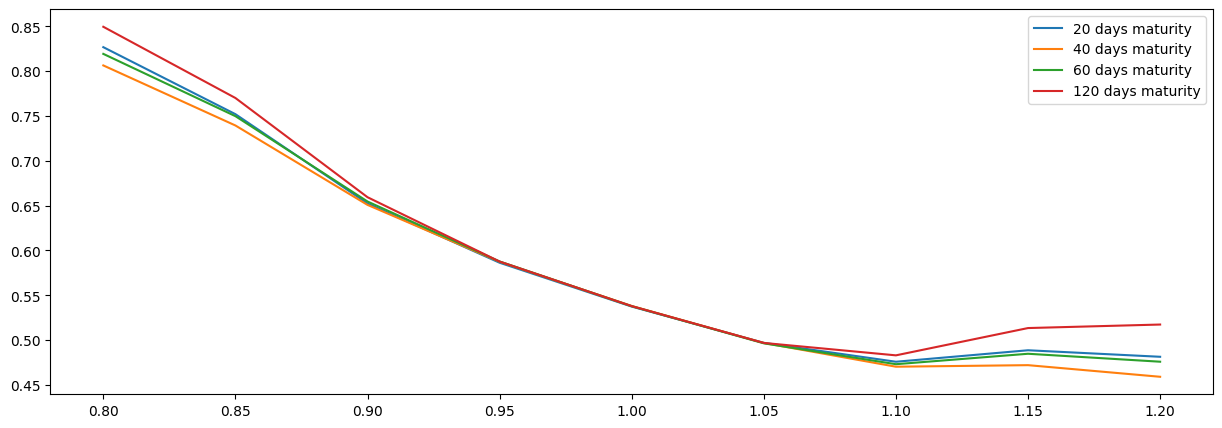

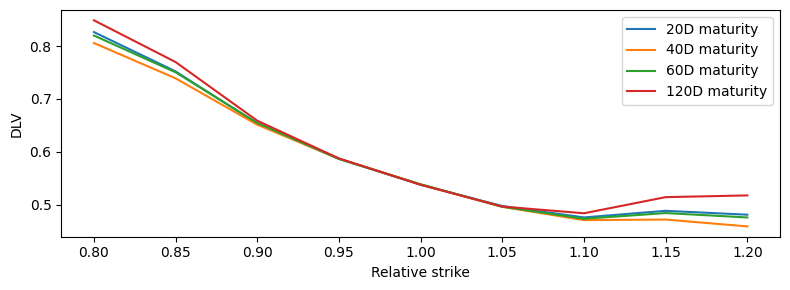

In [14]:
import numpy as np
import matplotlib.pyplot as plt

mu_mat = mean_grid

sigma_noise = 0.025

DLV_series = np.zeros((T, M, K))
for m in range(M):
    for k in range(K):
        DLV_series[:, m, k] = np.random.normal(mu_mat[m, k], sigma_noise, size=T)

mean_grid = np.mean(DLV_series, axis=0)

plt.figure(figsize=(8, 3))
for m in range(M):
    plt.plot(strikes, mean_grid[m], label=f"{maturities[m]}D maturity")
plt.xlabel("Relative strike")
plt.ylabel("DLV")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
DLV_series = np.array(DLV_series)   # Ensure it's a NumPy array
DLV_log = np.log(DLV_series)        # Shape: (T, M, K)

T, M, K = DLV_log.shape
DLV_log_flat = DLV_log.reshape(T, M * K)  # Shape: (T, M*K)

mean = DLV_log_flat.mean(axis=0)   # Shape: (M*K,)
std  = DLV_log_flat.std(axis=0)    # Shape: (M*K,)

DLV_flat = (DLV_log_flat - mean) / std  # Shape: (T, M*K)

In [17]:
df_m_std = pd.DataFrame({'mean': mean, 'std': std})
df_m_std.to_excel('dlv_mean_std.xlsx', index=False)

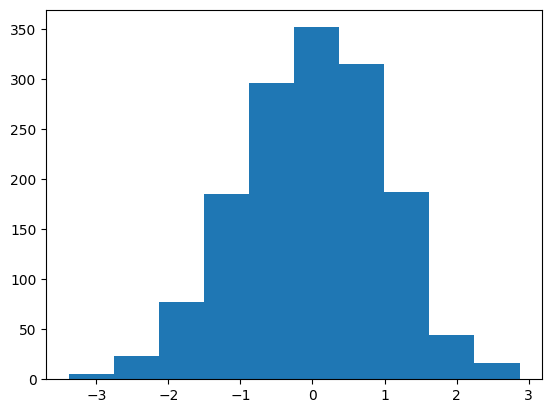

In [18]:
%matplotlib inline
plt.hist(DLV_flat[:,8])
plt.show()

In [19]:
train_idx, test_idx = train_test_split(np.arange(T), test_size=0.2, random_state=42, shuffle=True)
DLV_train = DLV_flat[train_idx]
DLV_test  = DLV_flat[test_idx]
class AE(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.02),              
            nn.Linear(64, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.02),             
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

def train_ae(model, train_data, test_data, epochs=1000, lr=1e-3, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
    test_tensor  = torch.tensor(test_data, dtype=torch.float32).to(device)
    
    best_test_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_tensor)
        loss = criterion(output, train_tensor)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_output = model(test_tensor)
            test_loss = criterion(test_output, test_tensor).item()
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        train_final = model(train_tensor)
        test_final  = model(test_tensor)
        train_loss = criterion(train_final, train_tensor).item()
        test_loss = criterion(test_final, test_tensor).item()
    return train_loss, test_loss


input_dim = DLV_train.shape[1]
results = []
for bottleneck in range(1, 11):
    model = AE(input_dim, bottleneck)
    train_loss, test_loss = train_ae(model, DLV_train, DLV_test, epochs=2000, lr=1e-3)
    results.append({'bottleneck': bottleneck, 'AE_train': train_loss, 'AE_test': test_loss})
    print(f"Bottleneck {bottleneck}: Train MSE {train_loss:.4f}, Test MSE {test_loss:.4f}")


Bottleneck 1: Train MSE 0.9708, Test MSE 0.9657
Bottleneck 2: Train MSE 0.9306, Test MSE 0.9406
Bottleneck 3: Train MSE 0.8893, Test MSE 0.9124
Bottleneck 4: Train MSE 0.8360, Test MSE 0.8876
Bottleneck 5: Train MSE 0.8116, Test MSE 0.8608
Bottleneck 6: Train MSE 0.7730, Test MSE 0.8371
Bottleneck 7: Train MSE 0.7423, Test MSE 0.8060
Bottleneck 8: Train MSE 0.7265, Test MSE 0.7812
Bottleneck 9: Train MSE 0.6853, Test MSE 0.7482
Bottleneck 10: Train MSE 0.6710, Test MSE 0.7301


In [20]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pca_train_mse = []
pca_test_mse = []
for dim in range(1, 11):
    pca = PCA(n_components=dim)
    pca.fit(DLV_train)
    DLV_train_recon = pca.inverse_transform(pca.transform(DLV_train))
    DLV_test_recon  = pca.inverse_transform(pca.transform(DLV_test))
    pca_train_mse.append(mean_squared_error(DLV_train, DLV_train_recon))
    pca_test_mse.append(mean_squared_error(DLV_test, DLV_test_recon))
    print(f"PCA {dim}: Train MSE {pca_train_mse[-1]:.4f}, Test MSE {pca_test_mse[-1]:.4f}")


PCA 1: Train MSE 0.9648, Test MSE 0.9657
PCA 2: Train MSE 0.9278, Test MSE 0.9379
PCA 3: Train MSE 0.8923, Test MSE 0.9109
PCA 4: Train MSE 0.8574, Test MSE 0.8841
PCA 5: Train MSE 0.8232, Test MSE 0.8548
PCA 6: Train MSE 0.7896, Test MSE 0.8294
PCA 7: Train MSE 0.7571, Test MSE 0.8032
PCA 8: Train MSE 0.7247, Test MSE 0.7785
PCA 9: Train MSE 0.6926, Test MSE 0.7504
PCA 10: Train MSE 0.6610, Test MSE 0.7240


In [21]:
from torch.utils.data import DataLoader, TensorDataset
X_tensor = torch.tensor(DLV_flat, dtype=torch.float32)
input_dim = DLV_flat.shape[1]
bottleneck_dim = 3

model = AE(input_dim, bottleneck_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
batch_size = 64  
num_epochs = 200
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in loader:
        batch_x = batch[0] 
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss:.5f}")
model.eval()
with torch.no_grad():
    bottleneck_series = model.encoder(X_tensor).numpy()


Epoch 0: Loss = 1.00071
Epoch 10: Loss = 0.90019
Epoch 20: Loss = 0.88557
Epoch 30: Loss = 0.87727
Epoch 40: Loss = 0.87127
Epoch 50: Loss = 0.86683
Epoch 60: Loss = 0.86293
Epoch 70: Loss = 0.86012
Epoch 80: Loss = 0.85725
Epoch 90: Loss = 0.85435
Epoch 100: Loss = 0.85305
Epoch 110: Loss = 0.85143
Epoch 120: Loss = 0.84996
Epoch 130: Loss = 0.84895
Epoch 140: Loss = 0.84679
Epoch 150: Loss = 0.84588
Epoch 160: Loss = 0.84342
Epoch 170: Loss = 0.84223
Epoch 180: Loss = 0.84188
Epoch 190: Loss = 0.84168


In [22]:
torch.save(model.state_dict(), "ae_model.pth")

# Load autoencoder model

In [24]:
class AE(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.02),            
            nn.Linear(64, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.02),             
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = AE(input_dim = 36, bottleneck_dim = 3)

# Load the saved state
model.load_state_dict(torch.load("ae_model.pth"))

<All keys matched successfully>

# Training the Normalising flow for compressed state

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import kstest, norm
from scipy.stats import kurtosis, skew
from statsmodels.tsa.stattools import acf 
from tqdm import tqdm
import math
import torch.nn.functional as F
import nflows
from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.transforms.autoregressive import MaskedPiecewiseLinearAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from torch.utils.data import DataLoader, TensorDataset
from nflows.transforms import (
    MaskedAffineAutoregressiveTransform,
    ReversePermutation,
    RandomPermutation
)

In [25]:
import torch
from torch.distributions import Normal, StudentT

def _sample_left_skewed_normal(n, *, mu=0.0,
                               sigma_left=2.5, sigma_right=1.0,
                               weight_left=0.70, device="cpu"):
    left_flag = (torch.rand(n, device=device) < weight_left)
    left  = Normal(mu, sigma_left ).sample((n,))
    right = Normal(mu, sigma_right).sample((n,))
    return torch.where(left_flag, left, right)

def sample_DLV_series(T,
                      sigma1_params = {"mu":0.0, "sigma":1.1},
                      sigma2_params = {"mu":0.0, "sigma_left":2.5,
                                       "sigma_right":1.0, "weight_left":0.70},
                      sigma3_params = {"mu":0.0, "sigma":1.4, "df":4},
                      device="cpu"):
    mu1, sig1 = sigma1_params["mu"], sigma1_params["sigma"]
    x1 = Normal(mu1, sig1).sample((T,))
    x2 = _sample_left_skewed_normal(T,
                                    mu           = sigma2_params["mu"],
                                    sigma_left   = sigma2_params["sigma_left"],
                                    sigma_right  = sigma2_params["sigma_right"],
                                    weight_left  = sigma2_params["weight_left"],
                                    device=device)
    mu3, sig3, df3 = (sigma3_params["mu"],
                      sigma3_params["sigma"],
                      sigma3_params["df"])
    x3 = StudentT(df3).sample((T,)) * sig3 + mu3

    return torch.stack([x1, x2, x3], dim=1).to(device)

# DLV_series = sample_DLV_series(
#    1000,
#    sigma1_params = {"mu":0.0, "sigma":1.0},
#    sigma2_params = {"mu":-0.3, "sigma_left":2.0,
#                     "sigma_right":0.7, "weight_left":0.0},
#    sigma3_params = {"mu":0, "sigma":1.0, "df":15},
# )

DLV_series = bottleneck_series


In [26]:
DVol_series = pd.DataFrame(DLV_series, columns=['latent_1', 'latent_2', 'latent_3'])
DVol_series.to_excel('compressed_latent_codes.xlsx', index=False)

# Work with loaded states

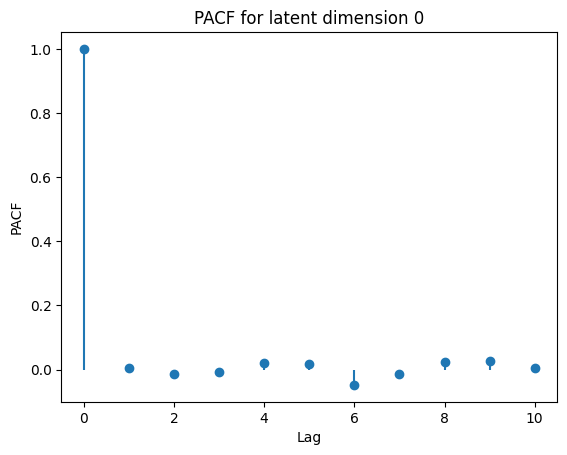

0.004399401386424051 -0.013943885309197674


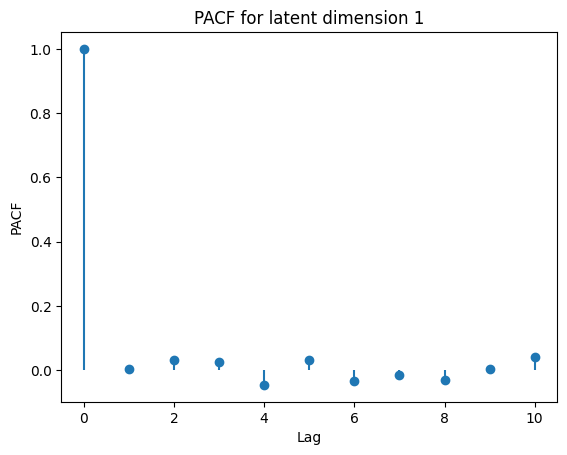

0.0034084470441397615 0.032699590353653656


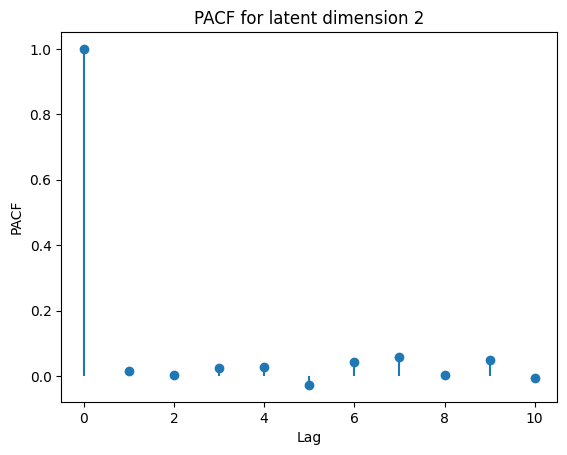

0.015711646254428998 0.002115752017020204


In [8]:
df_loaded = pd.read_excel('compressed_latent_codes.xlsx')
DLV_series = df_loaded.values 

from statsmodels.tsa.stattools import pacf
for i in range(DLV_series.shape[1]):
    pacf_vals = pacf(DLV_series[:, i], nlags=10)
    plt.stem(range(len(pacf_vals)), pacf_vals, basefmt=" ")
    plt.title(f'PACF for latent dimension {i}')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.show()
    print(pacf_vals[1], pacf_vals[2])

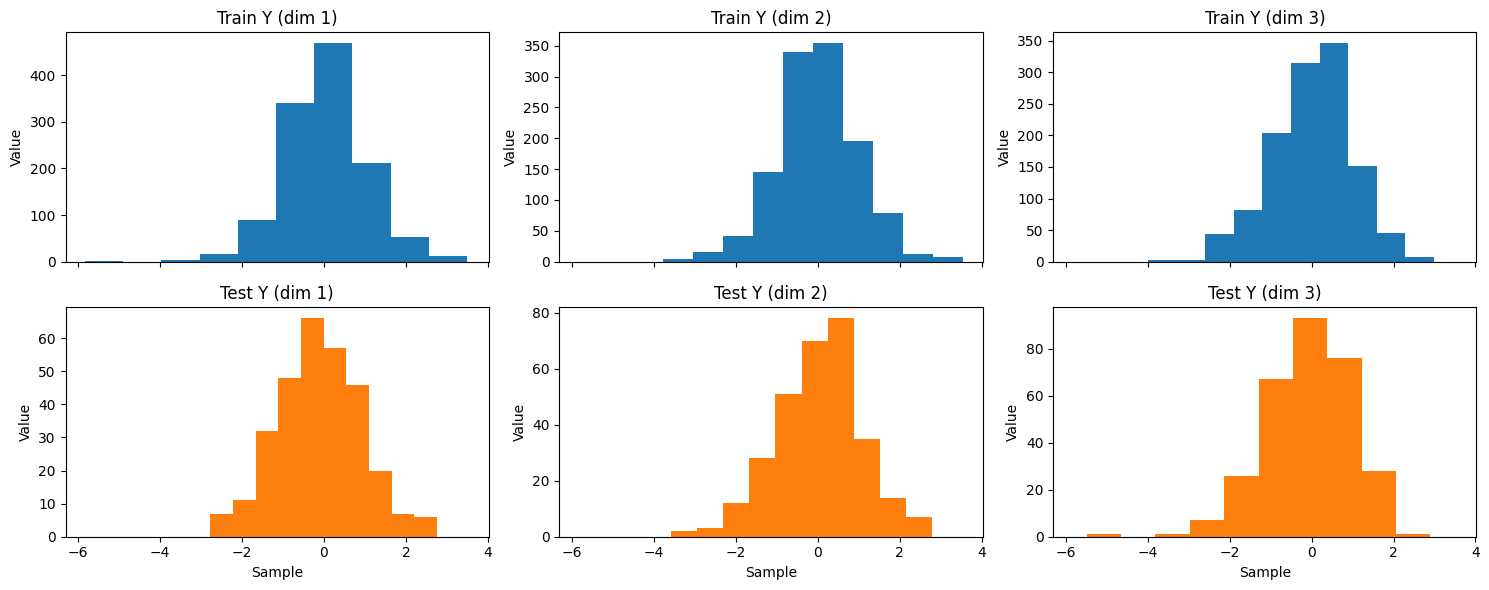

In [36]:
from torch.distributions import StudentT
%matplotlib inline

#DLV_series = torch.randn(T, 3) # For a Gaussian

#DLV_series = StudentT(df=1000).sample((T,3)) # For T distribution

#DLV_series = torch.distributions.Cauchy(0,1).sample((T,3))

#means = DLV_series.mean(dim=0, keepdim=True)  # shape: 1 x 3
#stds = DLV_series.std(dim=0, unbiased=False, keepdim=True)
means = DLV_series.mean(axis=0)  # shape: 1 x 3
stds = DLV_series.std(axis=0)
DLV_series_scaled = (DLV_series - means) / (stds + 1e-8)

def create_lagged_data_1d(series_1d, lag=2):
    X, Y = [], []
    for t in range(lag, len(series_1d)):
        X.append(series_1d[t-lag:t])
        Y.append(series_1d[t])
    return np.stack(X), np.stack(Y)
lag = 1  # or your chosen lag value
# For dimension 0 (first dimension)
X_dlv1, Y_dlv1 = create_lagged_data_1d(DLV_series_scaled[:, 0], lag=lag)
# For dimension 1 (second dimension)
X_dlv2, Y_dlv2 = create_lagged_data_1d(DLV_series_scaled[:, 1], lag=lag)
# For dimension 2 (third dimension)
X_dlv3, Y_dlv3 = create_lagged_data_1d(DLV_series_scaled[:, 2], lag=lag)

X_list = [X_dlv1, X_dlv2, X_dlv3]
Y_list = [Y_dlv1, Y_dlv2, Y_dlv3]

X_train_list, Y_train_list = [], []
X_val_list,   Y_val_list   = [], []
X_test_list,  Y_test_list  = [], []

for X_dlv, Y_dlv in zip(X_list, Y_list):
    X_dlv = torch.from_numpy(X_dlv).float()
    Y_dlv = torch.from_numpy(Y_dlv).float()
    
    N = X_dlv.shape[0]
    perm = np.random.permutation(N)
    X_shuffled = X_dlv[perm]
    Y_shuffled = Y_dlv[perm]
    
    n_train = int(0.80 * N)
    n_val = int(0.0005 * N)
    n_test = N - n_train - n_val   

    X_train_list.append(X_shuffled[:n_train])
    Y_train_list.append(Y_shuffled[:n_train])

    X_val_list.append(X_shuffled[n_train:n_train + n_val])
    Y_val_list.append(Y_shuffled[n_train:n_train + n_val])

    X_test_list.append(X_shuffled[n_train + n_val:])
    Y_test_list.append(Y_shuffled[n_train + n_val:])

fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex=True)

for i in range(3):
    # Training Ys
    axes[0, i].hist(Y_train_list[i].cpu().numpy(), color='tab:blue')
    axes[0, i].set_title(f'Train Y (dim {i+1})')
    axes[0, i].set_ylabel('Value')
    
    # Testing Ys
    axes[1, i].hist(Y_test_list[i].cpu().numpy(), color='tab:orange')
    axes[1, i].set_title(f'Test Y (dim {i+1})')
    axes[1, i].set_xlabel('Sample')
    axes[1, i].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [11]:
from tqdm import trange
import torch.nn.utils as nn_utils
import itertools
from torch.utils.data import Sampler
from nflows.distributions.normal import ConditionalDiagonalNormal
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.optim import Adam
from scipy.stats import kstest

def create_conditional_nspline_flow(input_dim, context_dim, hidden_features, num_bins, num_blocks, made_depth = 4, tail_bound=5):
    transforms = []
    for n in range(num_blocks):
        transform = MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features,
            context_features=context_dim,
            num_bins=num_bins,
            tails='linear',
            tail_bound=tail_bound,
            num_blocks = made_depth
        )
        transforms.append(transform)

        if n < num_blocks - 1:
            transforms.append(RandomPermutation(features=input_dim))
            
    transform = CompositeTransform(transforms)
    base_distribution = StandardNormal([input_dim])
    flow = Flow(transform, base_distribution)
    return flow

# Hyperparameters
#context = 1, flow = 2
hidden_features = 256
num_bins = 8
num_blocks = 3
made_depth = 3
tail_bound = 15

# Create three independent flows
flows = []
for i in range(3):
    flow = create_conditional_nspline_flow(
        input_dim=1,
        context_dim=1,
        hidden_features=hidden_features,
        num_bins=num_bins,
        num_blocks=num_blocks,
        made_depth=made_depth,
        tail_bound=tail_bound
    )
    flows.append(flow)
X_trains = [X_train_list[i].float() for i in range(3)]
Y_trains = [Y_train_list[i].float().reshape(-1, 1) for i in range(3)]

X_tests = [X_test_list[i].float() for i in range(3)]
Y_tests = [Y_test_list[i].float().reshape(-1, 1) for i in range(3)]

batch_size = 128

train_loaders = []
for i in range(3):
    dataset = TensorDataset(X_trains[i], Y_trains[i])
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    train_loaders.append(train_loader)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = []
test_losses = []
ks_pvals_train = []
ks_pvals_test = []
max_steps = 500
eval_every = 1
grad_clip_norm = 5
decay1_at = 5000
decay2_at = 8000

for flow in flows:
    flow.to(device)

optimizers = [Adam(flow.parameters(), lr=1e-3) for flow in flows]

step = 0
iterators = [itertools.cycle(loader) for loader in train_loaders]

dist_learn = [2]

while step < max_steps:
    for i in dist_learn:
        flows[i].train()
        try:
            context_batch, x_batch = next(iterators[i])
        except StopIteration:
            iterators[i] = iter(train_loaders[i])
            context_batch, x_batch = next(iterators[i])
        context_batch = context_batch.to(device)
        x_batch = x_batch.to(device)
        optimizers[i].zero_grad()
        loss = -flows[i].log_prob(inputs=x_batch, context=context_batch).mean()
        loss.backward()
        nn.utils.clip_grad_norm_(flows[i].parameters(), grad_clip_norm)
        optimizers[i].step()
        if step == decay1_at:
            for g in optimizers[i].param_groups:
                g["lr"] = 3e-4
        if step == decay2_at:
            for g in optimizers[i].param_groups:
                g["lr"] = 1e-5

    if (step + 1) % eval_every == 0 or step + 1 == max_steps:
        train_nlls = []
        test_nlls = []
        pvals_train = []
        pvals_test = []
        for i in dist_learn:
            flows[i].eval()
            with torch.no_grad():
                Y_train = Y_trains[i].to(device)
                X_train = X_trains[i].to(device)
                Y_test = Y_test_list[i].float().reshape(-1, 1).to(device)
                X_test = X_test_list[i].float().to(device)
                loss_eval = -flows[i].log_prob(inputs=Y_train, context=X_train).mean().item()
                train_nlls.append(loss_eval)
                loss_test = -flows[i].log_prob(inputs=Y_test, context=X_test).mean().item()
                test_nlls.append(loss_test)
               
                z_train, _ = flows[i]._transform.inverse(Y_train, context=X_train)
                z_train_np = z_train.cpu().numpy().reshape(-1)
                pval_train = kstest(z_train_np, 'norm', args=(0, 1))[1]
                pvals_train.append(pval_train)
                z_test, _ = flows[i]._transform.inverse(Y_test, context=X_test)
                z_test_np = z_test.cpu().numpy().reshape(-1)
                pval_test = kstest(z_test_np, 'norm', args=(0, 1))[1]
                pvals_test.append(pval_test)
       
        train_losses.append(np.mean(train_nlls))
        test_losses.append(np.mean(test_nlls))
        ks_pvals_train.append(pvals_train)
        ks_pvals_test.append(pvals_test)
        print(f"Step {step}/{max_steps} | Train NLL: {np.mean(train_nlls):.4f} | Test NLL: {np.mean(test_nlls):.4f}")
        print(f"KS p-values Train: {np.round(pvals_train, 4)} | KS p-values Test: {np.round(pvals_test, 4)}")
        if step > 10 and pval_train >= 0.2 and pval_test >= 0.2:
            print("Stopped as required pvals reached")
            break
    step += 1

ks_pvals_train = np.array(ks_pvals_train)  
ks_pvals_test  = np.array(ks_pvals_test)  
train_losses = np.array(train_losses)
test_losses  = np.array(test_losses)



NameError: name 'MaskedPiecewiseRationalQuadraticAutoregressiveTransform' is not defined

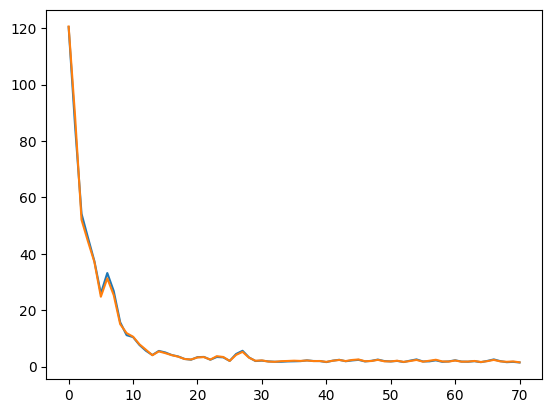

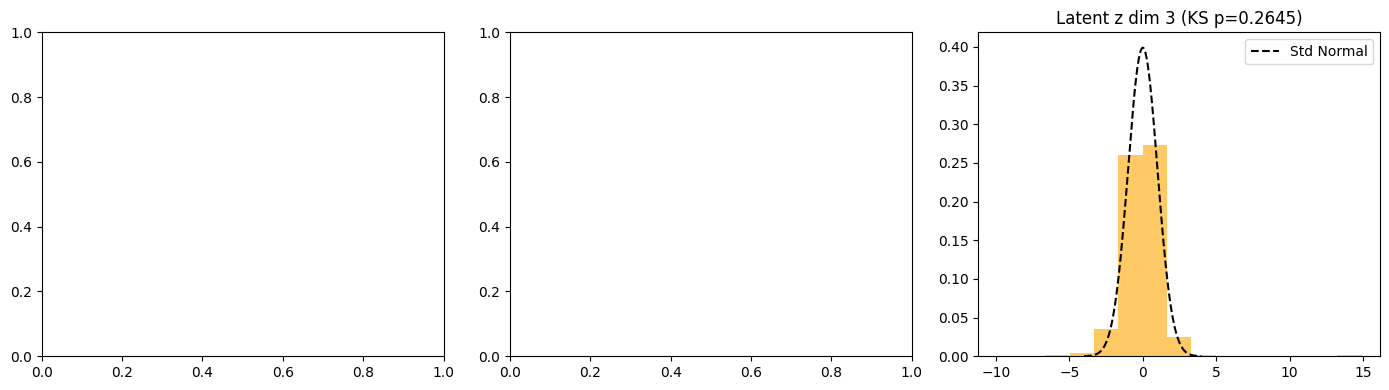

In [58]:
plt.plot(train_losses)
plt.plot(test_losses)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i in dist_learn:
    flows[i].eval()
    with torch.no_grad():
        device = next(flows[i].parameters()).device
        z_val, _ = flows[i]._transform.inverse(
            Y_trains[i].to(device),
            context=X_trains[i].to(device)
        )
    zi = z_val.cpu().numpy().reshape(-1)
    ks_stat, ks_pval = kstest(zi, 'norm')
    axes[i].hist(zi, bins=15, density=True, alpha=0.6, color='orange')
    xgrid = np.linspace(-4, 4, 200)
    axes[i].plot(xgrid, (1/np.sqrt(2*np.pi))*np.exp(-0.5*xgrid**2), 'k--', label='Std Normal')
    axes[i].set_title(f'Latent z dim {i+1} (KS p={ks_pval:.4f})')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [70]:
flow2 = flows[2]
torch.save(flow2.state_dict(), "flow2_model.pth")

# Loading parameters

In [13]:
def create_conditional_nspline_flow(input_dim, context_dim, hidden_features, num_bins, num_blocks, made_depth = 4, tail_bound=5):
    transforms = []
    for n in range(num_blocks):
        transform = MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features,
            context_features=context_dim,
            num_bins=num_bins,
            tails='linear',
            tail_bound=tail_bound,
            num_blocks = made_depth
        )
        transforms.append(transform)

        if n < num_blocks - 1:
            transforms.append(RandomPermutation(features=input_dim))
            
    transform = CompositeTransform(transforms)
    base_distribution = StandardNormal([input_dim])
    flow = Flow(transform, base_distribution)
    return flow
    
# For context = 1
flow10 = create_conditional_nspline_flow(input_dim=1,context_dim=1,hidden_features=64,num_bins=8,num_blocks=3,made_depth=3,tail_bound=15)
flow10.load_state_dict(torch.load("flow0_model.pth"))

flow11 = create_conditional_nspline_flow(input_dim=1,context_dim=1,hidden_features=64,num_bins=8,num_blocks=3,made_depth=3,tail_bound=15)
flow11.load_state_dict(torch.load("flow1_model.pth"))

flow12 = create_conditional_nspline_flow(input_dim=1,context_dim=1,hidden_features=256,num_bins=8,num_blocks=3,made_depth=3,tail_bound=15)
flow12.load_state_dict(torch.load("flow2_model.pth"))

# For context = 2
flow20 = create_conditional_nspline_flow(input_dim=1,context_dim=2,hidden_features=128,num_bins=8,num_blocks=6,made_depth=3,tail_bound=15)
flow20.load_state_dict(torch.load("flow0_context2_model.pth"))

flow21 = create_conditional_nspline_flow(input_dim=1,context_dim=2,hidden_features=128,num_bins=8,num_blocks=6,made_depth=3,tail_bound=15)
flow21.load_state_dict(torch.load("flow1_context2_model.pth"))

flow22 = create_conditional_nspline_flow(input_dim=1,context_dim=2,hidden_features=512,num_bins=8,num_blocks=3,made_depth=3,tail_bound=15)
flow22.load_state_dict(torch.load("flow2_context2_model.pth"))

<All keys matched successfully>

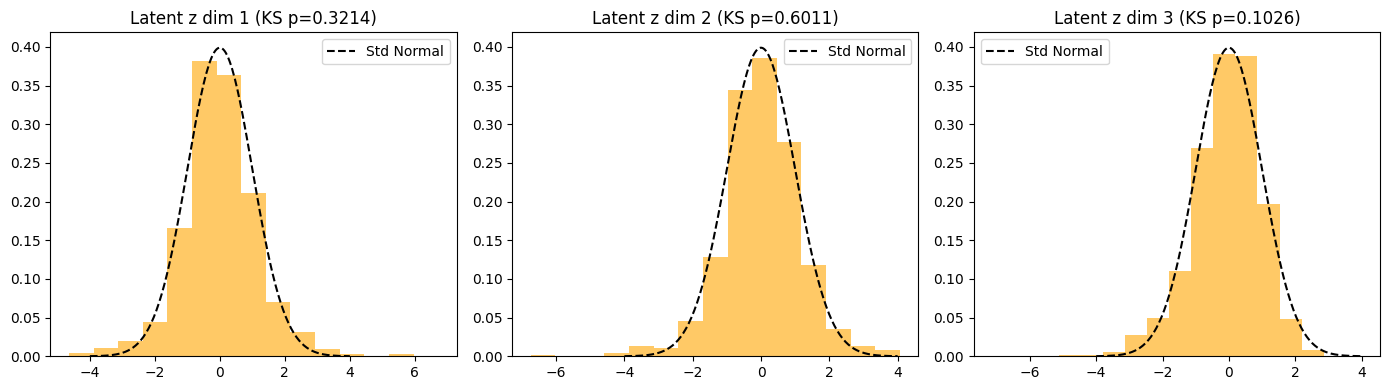

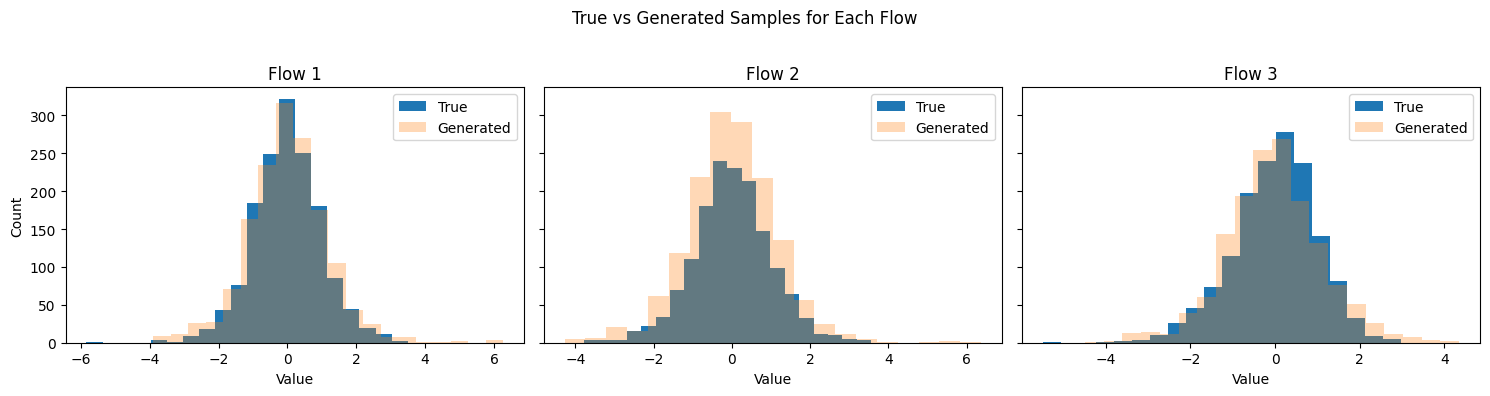

In [37]:
flows = [flow10, flow11, flow12]
X_dlvs = [X_dlv1, X_dlv2, X_dlv3]
Y_dlvs = [Y_dlv1, Y_dlv2, Y_dlv3]
X_dlvs_tensor = [torch.tensor(x, dtype=torch.float32).float() for x in X_dlvs]
Y_dlvs_tensor = [torch.tensor(y, dtype=torch.float32).float().reshape(-1,1) for y in Y_dlvs]


colors = ['C0', 'C1', 'C2']
labels = ['Flow 1', 'Flow 2', 'Flow 3']
sampled_DLVs = []

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i in range(len(flows)):
    flow = flows[i]
    X = X_dlvs_tensor[i]
    Y = Y_dlvs_tensor[i]
    flow.eval()
    with torch.no_grad():
        device = next(flow.parameters()).device
        z_val, _ = flow._transform.inverse(
            Y,
            context=X)
    zi = z_val.cpu().numpy().reshape(-1)
    ks_stat, ks_pval = kstest(zi, 'norm')
    axes[i].hist(zi, bins=15, density=True, alpha=0.6, color='orange')
    xgrid = np.linspace(-4, 4, 200)
    axes[i].plot(xgrid, (1/np.sqrt(2*np.pi))*np.exp(-0.5*xgrid**2), 'k--', label='Std Normal')
    axes[i].set_title(f'Latent z dim {i+1} (KS p={ks_pval:.4f})')
    axes[i].legend()

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True) 

for i in range(3):
    context = torch.from_numpy(X_dlvs[i]).float()
    with torch.no_grad():
        flow = flows[0]
        samples = flow.sample(num_samples=1, context=context).squeeze(0) 
        sampled_DLVs.append(samples.cpu().numpy().squeeze())
    
   
    axs[i].hist(Y_dlvs[i], bins=20, label='True')
    axs[i].hist(samples[:,0,0].numpy().flatten(), bins=20, alpha=0.3, label='Generated')
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Value')
    if i == 0:
        axs[i].set_ylabel('Count')
    axs[i].legend()

plt.suptitle("True vs Generated Samples for Each Flow")
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

# Decoder to get the entire dlv grid

In [22]:
latent1 = sampled_DLVs[0] 
latent2 = sampled_DLVs[1]  
latent3 = sampled_DLVs[2] 

latent1_rescaled = latent1 * stds[0] + means[0]
latent2_rescaled = latent2 * stds[1] + means[1]
latent3_rescaled = latent3 * stds[2] + means[2]

stacked_DLVs = np.stack([latent1_rescaled, latent2_rescaled, latent3_rescaled], axis=1)

# Stacked_DLVs : Compressed, scaled DLVs I get after modeling
# DLV_series : Orignal scaled compressed DLVs 

In [31]:
corr_matrix_new = np.corrcoef(stacked_DLVs, rowvar=False)  
print(corr_matrix_new)
corr_matrix_or = np.corrcoef(DLV_series, rowvar=False) 
print(corr_matrix_or)

[[ 1.         -0.02739381 -0.03234687]
 [-0.02739381  1.          0.01888248]
 [-0.03234687  0.01888248  1.        ]]
[[ 1.         -0.09174682 -0.01027163]
 [-0.09174682  1.          0.02620303]
 [-0.01027163  0.02620303  1.        ]]


In [47]:
DLV_series_rescaled = DLV_series * stds + means
model.eval()
DLV_series_rescaled_tensors = torch.from_numpy(DLV_series_rescaled).float()

with torch.no_grad():
    reconstructed_ORDLVs = model.decoder(DLV_series_rescaled_tensors).cpu().numpy()

In [25]:
model.eval()
stacked_DLVs_tensors = torch.from_numpy(stacked_DLVs).float()

with torch.no_grad():
    reconstructed_DLVs = model.decoder(stacked_DLVs_tensors).cpu().numpy()

In [26]:
mean_std_df = pd.read_excel('dlv_mean_std.xlsx')
mean = mean_std_df['mean'].values  
std = mean_std_df['std'].values     

DLV_log_flat_rec = reconstructed_DLVs * std + mean    
T = DLV_log_flat_rec.shape[0]
strikes    = np.linspace(0.80, 1.20, 9)         
maturities = np.array([20, 40, 60, 120])        
M, K       = len(maturities), len(strikes)
DLV_log_rec = DLV_log_flat_rec.reshape(T, M, K)

DLV_rec = np.exp(DLV_log_rec)  

# Get call price grids

In [39]:
spot_df = df['Adjusted Close'].values
spot_prices = spot_df[1:]  

In [40]:
def black_scholes_call(S, K, T, sigma, r=0.0):
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [41]:
T_, M, K_ = DLV_rec.shape
call_prices = np.zeros((T_, M, K_))

for t in range(T_):
    S0 = spot_prices[t]
    for m in range(M):
        tau = maturities[m]
        for k in range(K_):
            strike = strikes[k]
            sigma = DLV_rec[t, m, k]
            call_prices[t, m, k] = black_scholes_call(S0, strike, tau, sigma, r=0.04)